# PointNet

This is an implementation of [PointNet: Deep Learning on Point Sets for 3D Classification and Segmentation](https://arxiv.org/abs/1612.00593) using PyTorch.


## Getting started

Don't forget to turn on GPU if you want to start training directly. 


**Runtime** -> **Change runtime type**-> **Hardware accelerator**



In [1]:
import numpy as np
import math
import random
import os
import torch
import scipy.spatial.distance
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

import plotly.graph_objects as go
import plotly.express as px

In [2]:
!pip install path.py;
from path import Path

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
random.seed = 42

In [ ]:
import os
from google.colab import drive
drive.mount('/content/gdrive')

Download the [dataset](http://3dvision.princeton.edu/projects/2014/3DShapeNets/) directly to the Google Colab Runtime. It comprises 10 categories, 3,991 models for training and 908 for testing.

In [5]:
!unzip -q ModelNet10.zip;

In [6]:
path = Path("ModelNet10")

In [7]:
folders = [dir for dir in sorted(os.listdir(path)) if os.path.isdir(path/dir)]
classes = {folder: i for i, folder in enumerate(folders)};
classes

{'bathtub': 0,
 'bed': 1,
 'chair': 2,
 'desk': 3,
 'dresser': 4,
 'monitor': 5,
 'night_stand': 6,
 'sofa': 7,
 'table': 8,
 'toilet': 9}

This dataset consists of **.off** files that contain meshes represented by *vertices* and *triangular faces*. 

We will need a function to read this type of files:

In [8]:
def read_off(file):
    if 'OFF' != file.readline().strip():
        raise('Not a valid OFF header')
    n_verts, n_faces, __ = tuple([int(s) for s in file.readline().strip().split(' ')])
    verts = [[float(s) for s in file.readline().strip().split(' ')] for i_vert in range(n_verts)]
    faces = [[int(s) for s in file.readline().strip().split(' ')][1:] for i_face in range(n_faces)]
    return verts, faces

In [9]:
with open(path/"bed/train/bed_0001.off", 'r') as f:
  verts, faces = read_off(f)

In [10]:
i,j,k = np.array(faces).T
x,y,z = np.array(verts).T

In [11]:
len(x)

2095

Don't be afraid of this huge function. It's  just to display animated rotation of meshes and point clouds.

In [12]:
def visualize_rotate(data):
    x_eye, y_eye, z_eye = 1.25, 1.25, 0.8
    frames=[]

    def rotate_z(x, y, z, theta):
        w = x+1j*y
        return np.real(np.exp(1j*theta)*w), np.imag(np.exp(1j*theta)*w), z

    for t in np.arange(0, 10.26, 0.1):
        xe, ye, ze = rotate_z(x_eye, y_eye, z_eye, -t)
        frames.append(dict(layout=dict(scene=dict(camera=dict(eye=dict(x=xe, y=ye, z=ze))))))
    fig = go.Figure(data=data,
                    layout=go.Layout(
                        updatemenus=[dict(type='buttons',
                                    showactive=False,
                                    y=1,
                                    x=0.8,
                                    xanchor='left',
                                    yanchor='bottom',
                                    pad=dict(t=45, r=10),
                                    buttons=[dict(label='Play',
                                                    method='animate',
                                                    args=[None, dict(frame=dict(duration=50, redraw=True),
                                                                    transition=dict(duration=0),
                                                                    fromcurrent=True,
                                                                    mode='immediate'
                                                                    )]
                                                    )
                                            ]
                                    )
                                ]
                    ),
                    frames=frames
            )

    return fig

In [13]:
visualize_rotate([go.Mesh3d(x=x, y=y, z=z, color='lightpink', opacity=0.50, i=i,j=j,k=k)]).show()

This mesh definitely looks like a bed.

In [14]:
visualize_rotate([go.Scatter3d(x=x, y=y, z=z,
                                   mode='markers')]).show()

Unfortunately, that's not the case for its vertices. It would be difficult for PointNet to classify point clouds like this one.

First things first, let's write a function to accurately visualize point clouds so we could see vertices better.

In [15]:
def pcshow(xs,ys,zs):
    data=[go.Scatter3d(x=xs, y=ys, z=zs,
                                   mode='markers')]
    fig = visualize_rotate(data)
    fig.update_traces(marker=dict(size=2,
                      line=dict(width=2,
                      color='DarkSlateGrey')),
                      selector=dict(mode='markers'))
    fig.show()
    

In [16]:
pcshow(x,y,z)

## Transforms

As we want it to look more like a real bed, let's write a function to sample points on the surface uniformly.

 ### Sample points

In [17]:
class PointSampler(object):
    def __init__(self, output_size):
        assert isinstance(output_size, int)
        self.output_size = output_size
    
    def triangle_area(self, pt1, pt2, pt3):
        side_a = np.linalg.norm(pt1 - pt2)
        side_b = np.linalg.norm(pt2 - pt3)
        side_c = np.linalg.norm(pt3 - pt1)
        s = 0.5 * ( side_a + side_b + side_c)
        return max(s * (s - side_a) * (s - side_b) * (s - side_c), 0)**0.5

    def sample_point(self, pt1, pt2, pt3):
        # barycentric coordinates on a triangle
        # https://mathworld.wolfram.com/BarycentricCoordinates.html
        s, t = sorted([random.random(), random.random()])
        f = lambda i: s * pt1[i] + (t-s)*pt2[i] + (1-t)*pt3[i]
        return (f(0), f(1), f(2))
        
    
    def __call__(self, mesh):
        verts, faces = mesh
        verts = np.array(verts)
        areas = np.zeros((len(faces)))

        for i in range(len(areas)):
            areas[i] = (self.triangle_area(verts[faces[i][0]],
                                           verts[faces[i][1]],
                                           verts[faces[i][2]]))
            
        sampled_faces = (random.choices(faces, 
                                      weights=areas,
                                      cum_weights=None,
                                      k=self.output_size))
        
        sampled_points = np.zeros((self.output_size, 3))

        for i in range(len(sampled_faces)):
            sampled_points[i] = (self.sample_point(verts[sampled_faces[i][0]],
                                                   verts[sampled_faces[i][1]],
                                                   verts[sampled_faces[i][2]]))
        
        return sampled_points
    

In [18]:
pointcloud = PointSampler(3000)((verts, faces))

In [19]:
pcshow(*pointcloud.T)

This pointcloud looks much more like a bed!

### Normalize

Unit sphere

In [20]:
class Normalize(object):
    def __call__(self, pointcloud):
        assert len(pointcloud.shape)==2
        
        norm_pointcloud = pointcloud - np.mean(pointcloud, axis=0) 
        norm_pointcloud /= np.max(np.linalg.norm(norm_pointcloud, axis=1))

        return  norm_pointcloud

In [21]:
norm_pointcloud = Normalize()(pointcloud)

In [22]:
pcshow(*norm_pointcloud.T)

Notice that axis limits have changed.

### Augmentations

Let's add *random rotation* of the whole pointcloud and random noise to its points.

In [23]:
class RandRotation_z(object):
    def __call__(self, pointcloud):
        assert len(pointcloud.shape)==2

        theta = random.random() * 2. * math.pi
        rot_matrix = np.array([[ math.cos(theta), -math.sin(theta),    0],
                               [ math.sin(theta),  math.cos(theta),    0],
                               [0,                             0,      1]])
        
        rot_pointcloud = rot_matrix.dot(pointcloud.T).T
        return  rot_pointcloud
    
class RandomNoise(object):
    def __call__(self, pointcloud):
        assert len(pointcloud.shape)==2

        noise = np.random.normal(0, 0.02, (pointcloud.shape))
    
        noisy_pointcloud = pointcloud + noise
        return  noisy_pointcloud

In [24]:
rot_pointcloud = RandRotation_z()(norm_pointcloud)
noisy_rot_pointcloud = RandomNoise()(rot_pointcloud)

In [25]:
pcshow(*noisy_rot_pointcloud.T)

### ToTensor

In [26]:
class ToTensor(object):
    def __call__(self, pointcloud):
        assert len(pointcloud.shape)==2

        return torch.from_numpy(pointcloud)

In [27]:
ToTensor()(noisy_rot_pointcloud)

tensor([[-0.3253,  0.4097, -0.0086],
        [-0.7297,  0.1638, -0.1020],
        [ 0.5602, -0.3422, -0.0106],
        ...,
        [-0.8440, -0.2227, -0.1490],
        [ 0.2555,  0.6397,  0.2122],
        [ 0.1826,  0.0312,  0.0820]], dtype=torch.float64)

In [28]:
def default_transforms():
    return transforms.Compose([
                                PointSampler(1024),
                                Normalize(),
                                ToTensor()
                              ])

## Dataset

Now we can create a [custom PyTorch Dataset](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html)

In [ ]:
!wget https://github.com/58191554/PointNet-Project/blob/main/pre_sample.zip

In [29]:
class PointCloudData(Dataset):
    def __init__(self, root_dir, valid=False, folder="train", transform=default_transforms()):
        self.root_dir = root_dir
        folders = [dir for dir in sorted(os.listdir(root_dir)) if os.path.isdir(root_dir/dir)]
        self.classes = {folder: i for i, folder in enumerate(folders)}
        self.transforms = transform if not valid else default_transforms()
        self.valid = valid
        self.files = []
        for category in self.classes.keys():
            new_dir = root_dir/Path(category)/folder
            for file in os.listdir(new_dir):
                if file.endswith('.off'):
                    sample = {}
                    sample['pcd_path'] = new_dir/file
                    sample['category'] = category
                    self.files.append(sample)

    def __len__(self):
        return len(self.files)

    def __preproc__(self, file):
        verts, faces = read_off(file)
        if self.transforms:
            pointcloud = self.transforms((verts, faces))
        return pointcloud

    def __getitem__(self, idx):
        pcd_path = self.files[idx]['pcd_path']
        category = self.files[idx]['category']
        with open(pcd_path, 'r') as f:
            pointcloud = self.__preproc__(f)
        return {'pointcloud': pointcloud, 
                'category': self.classes[category]}

Transforms for training. 1024 points per cloud as in the paper!

In [30]:
train_transforms = transforms.Compose([
                    Normalize(),
                    RandRotation_z(),
                    RandomNoise(),
                    ToTensor()
                    ])

In [31]:
train_ds = PointCloudData(path, transform=train_transforms)
valid_ds = PointCloudData(path, valid=True, folder='test', transform=train_transforms)

In [32]:
inv_classes = {i: cat for cat, i in train_ds.classes.items()};
inv_classes

{0: 'bathtub',
 1: 'bed',
 2: 'chair',
 3: 'desk',
 4: 'dresser',
 5: 'monitor',
 6: 'night_stand',
 7: 'sofa',
 8: 'table',
 9: 'toilet'}

In [33]:
print('Train dataset size: ', len(train_ds))
print('Valid dataset size: ', len(valid_ds))
print('Number of classes: ', len(train_ds.classes))
print('Sample pointcloud shape: ', train_ds[0]['pointcloud'].size())
print('Class: ', inv_classes[train_ds[0]['category']])

Train dataset size:  3991
Valid dataset size:  908
Number of classes:  10
Sample pointcloud shape:  torch.Size([1024, 3])
Class:  bathtub


In [112]:
train_loader = DataLoader(dataset=train_ds, batch_size=32, shuffle=True)
valid_loader = DataLoader(dataset=valid_ds, batch_size=64)

## Model

In [84]:
import torch
import torch.nn as nn
import numpy as np
import torch.nn.functional as F

In [ ]:
class Tnet(nn.Module):
    """
    T-Net is a type of spatial transformer network (STN) that learns a kxk transformation matrix
    for a given point cloud. The matrix is then used to transform the point cloud to a canonical
    pose. It consists of two parts: a convolutional network and a fully connected network.
    The convolutional network maps the input point cloud to a feature space and the fully connected
    network learns the transformation matrix from the feature space.
    """
    def __init__(self, hidden_sizes_conv=[64, 128, 1024], hidden_sizes_fc=[512, 256], k=3):
        super().__init__()
        self.k=k
        self.hidden_sizes_conv=hidden_sizes_conv
        self.hidden_sizes_fc=hidden_sizes_fc
        self.fc = nn.Linear(hidden_sizes_fc[-1],k*k)
        self.conv = self._build_conv()
        self.fc = self._build_fc()
  
    def _build_conv(self):
        ########################################################################
        # TODO: Builds the convolutional network that maps the input point cloud 
        # to a feature space
        # Hint: consisting of a series of convolutional layers with batch 
        # normalization and ReLU activation.
        ########################################################################
        layers = []
        prev_size = self.k
        for layer_id, size in enumerate(self.hidden_sizes_conv):
            bn = nn.BatchNorm1d(size)
            conv = nn.Conv1d(prev_size, size,1)
            layers.append(conv)
            layers.append(bn)
            layers.append(nn.ReLU())
            prev_size = size
        ########################################################################
        return nn.Sequential(*layers)
  
    def _build_fc(self):

        ########################################################################
        # TODO:  the fully connected network that takes the feature space and 
        # learns the transformation matrix. 
        # It consists of a series of fully connected layers with batch
        #  normalization and ReLU activation, followed by a linear layer that 
        # outputs a kxk matrix.
        ########################################################################

        layers = []
        prev_size = self.hidden_sizes_conv[-1]
        for layer_id, size in enumerate(self.hidden_sizes_fc):
            bn = nn.BatchNorm1d(size)
            fc = nn.Linear(prev_size, size)
            layers.append(fc)
            layers.append(bn)
            layers.append(nn.ReLU())
            prev_size = size
        ########################################################################
        return nn.Sequential(*layers)
      

    def forward(self, input):
        ########################################################################
        # TODO: Performs the forward pass of the T-Net. 
        # It first applies the convolutional network to the input point cloud 
        # to obtain a feature space. 
        # Then, it applies the fully connected network to the feature space to 
        # obtain the kxk transformation matrix. Finally, it applies the
        # transformation matrix to the input point cloud to transform it to a 
        # canonical pose.
        ########################################################################

        # input.shape (bs,n,3)
        bs = input.size(0)
        #三层1*1的卷积 相当于share mlp
        
        xb = self.conv(input)   #3->64->128->1024
        #torch.nn.MaxPool1d(kernel_size, stride=None, padding=0, dilation=1, return_indices=False, ceil_mode=False)
        #bs*n*1024->bs*1024*1
        # print(xb.shape)
        pool = nn.MaxPool1d(xb.size(-1))(xb)
        # print(pool.shape)
        #faltten
         #保留batch来做flatten
        #bs*1*1024->bs*1024
        flat = nn.Flatten(1)(pool)
        #fully connected layer
        #1024->512->256
        xb = self.fc(flat)
      
        #initialize as identity
        #生成b*k*k的单位矩阵
        init = torch.eye(self.k, requires_grad=True).repeat(bs,1,1)
        if xb.is_cuda:
          init=init.cuda()
        #b*256->b*(k*k)->b*k*k + init
        #init是用来初始化矩阵的
        matrix = self.fc(xb).view(-1,self.k,self.k) + init
        #input b*n*k
        return matrix

In [ ]:
class Transform(nn.Module):
    def __init__(self, input_size:int, feature_size:int, sharedMLP1_layers, sharedMLP2_layers, batch_norm = True):
        """
        Transform class is all the pipeline to get a global feature
                 _____________________                                     _______________                 ___________________       _______________
                |                     |                                   |               |                |                 |     |               |                    
        x -->   |   input transform   | --> y (canonical point cloud) --> |  shared MLP   | --> feature -->|feature transform| --> |  shared MLP   | --> max pooling --> z
                |_____________________|                                   |_______________|                |_________________|     |  _____________|
        The transform class is a neural networknet architecture that go throught 2 pairs of spactial transform net and shared MLP.
        The STN is the T-Net that implement above, and the shared-MLP can be regarded as a one-dimensional convolutional layer.

        the input x as a point cloud data of (nx3) shape first compute the 3x3 transform matrix and multiplied with the transform matrix to get a (nx3) transformed point cloud.

        the last_activate bool is True when you want to add the last layer with activation function.
        """
        super().__init__()
        self.batch_norm = True
        
        self.input_transform = Tnet(k=3)
        self.feature_transform = Tnet(k=64)

        self.sharedMLP1 = self._build_sharedMLP(input_size, sharedMLP1_layers, last_activate=True)
        self.sharedMLP2 = self._build_sharedMLP(feature_size, sharedMLP2_layers, last_activate=False)

    def _build_sharedMLP(self, input_dim, sharedMLP_layers, last_activate = True):
        layers = []
        prev_size = input_dim
        for layer_id, size in enumerate(sharedMLP_layers):
            layers.append(nn.Conv1d(prev_size, size, 1))

            if self.batch_norm:
                layers.append(nn.BatchNorm1d(size))

            if (layer_id < len(sharedMLP_layers)-1) or last_activate:
                layers.append(nn.ReLU())

            prev_size = size
        return nn.Sequential(*layers)
       
    def forward(self, input):     #input:[batch_size, 3, 1024] output:[batch_size, 1024]
    
        ########################################################################
        # TODO: Implement the code to multiply the transform matrix and the point
        # cloud. The transformed x should be the same shape of x 
        ########################################################################
        matrix3x3 = self.input_transform(input)     #[batch_size, 3, 3]
        # batch matrix multiplication
        xb = torch.bmm(torch.transpose(input,1,2), matrix3x3).transpose(1,2)     #[batch_size, 3, 1024]
        xb = self.sharedMLP1(xb)

        matrix64x64 = self.feature_transform(xb)     #[batch_size, 64, 64]
        xb = torch.bmm(torch.transpose(xb,1,2), matrix64x64).transpose(1,2)     #[batch_size, 64, 1024]
        xb = self.shareMLP2(xb)

        xb = nn.MaxPool1d(xb.size(-1))(xb)     #[batch_size, 1024, 1]
        output = nn.Flatten(1)(xb)     #[batch_size, 1024]
        ########################################################################
        return output, matrix3x3, matrix64x64

In [ ]:
class PointNet(nn.Module):
    def __init__(self, sharedMLP1_layers, sharedMLP2_layers, fc_layers, classes = 10, batch_norm = True, dropout_rate = 0.3):
        """
        Point Net the whole neural network for the classification of point cloud data
                    _________                         ___     
        input x--->|Transform|---> global feature--->|MLP|---> scores
                   |_________|                       |___|
            args:   sharedMLP1_layers is the first shared MLP in Transform class
                    sharedMLP2_layers is the second shared MLP in Transorm class
                The MLP has the structure of 
                    [Linear] -> [Batch Norm] -> [ReLU] -> [Dropout] -> [Linear] -> ... -> [Linear] -> [Batch Norm] -> [ReLU] -> [Linear of class size]

                
        """
        super().__init__()
        self.transform = Transform(input_size=3, feature_size=64, sharedMLP1_layers=sharedMLP1_layers, sharedMLP2_layers=sharedMLP2_layers)

        ########################################################################
        #TODO: Implement the MLP with given fc_layers list (the last layer 
        #   should be classes number)
        ########################################################################
        self.fully_connectedLayers = self._build_fc(sharedMLP2_layers[-1], fc_layers, classes, dropout_rate)
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, classes)
        

        self.bn1 = nn.BatchNorm1d(512)
        self.bn2 = nn.BatchNorm1d(256)
        self.dropout = nn.Dropout(dropout_rate)
        self.logsoftmax = nn.LogSoftmax(dim=1)

    def _build_fc(self, input_dim, fc_layers, cls_num, dropout_rate):
        layers = []
        prev_size = input_dim
        for layer_id, size in enumerate(fc_layers):
            layers.append(nn.Linear(prev_size, size, 1))

            if self.batch_norm:
                layers.append(nn.BatchNorm1d(size))

            if layer_id < len(fc_layers):
                layers.append(nn.ReLU())

            if layer_id < len(fc_layers)-1:
                layers.append(nn.Dropout(dropout_rate))

            prev_size = size
        
        layers.append(nn.Linear(cls_num))
        return nn.Sequential(*layers)
        

    def forward(self, input):
        xb, matrix3x3, matrix64x64 = self.transform(input)
        xb = F.relu(self.bn1(self.fc1(xb)))
        xb = F.relu(self.bn2(self.dropout(self.fc2(xb))))
        output = self.fc3(xb)
        return self.logsoftmax(output), matrix3x3, matrix64x64

In [85]:
def pointnetloss(outputs, labels, m3x3, m64x64, alpha = 0.0001):
    criterion = torch.nn.NLLLoss()
    bs=outputs.size(0)
    id3x3 = torch.eye(3, requires_grad=True).repeat(bs,1,1)       #identity matrix repeat batch_size times
    id64x64 = torch.eye(64, requires_grad=True).repeat(bs,1,1)
    if outputs.is_cuda:
        id3x3=id3x3.cuda()
        id64x64=id64x64.cuda()
    diff3x3 = id3x3-torch.bmm(m3x3,m3x3.transpose(1,2))       #Loss:I-A.t@A
    diff64x64 = id64x64-torch.bmm(m64x64,m64x64.transpose(1,2))
    return criterion(outputs, labels) + alpha * (torch.norm(diff3x3)+torch.norm(diff64x64)) / float(bs)

## Training loop

You can find a pretrained model [here](https://drive.google.com/open?id=1nDG0maaqoTkRkVsOLtUAR9X3kn__LMSL)

In [88]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [86]:
pointnet = PointNet()
pointnet.to(device);

In [87]:
optimizer = torch.optim.Adam(pointnet.parameters(), lr=0.001)

In [89]:
from tqdm.notebook import trange, tqdm

In [115]:
class Experiment:
    def __init__(self, train_data, val_data, model: nn.Module,
                 lr: float, save=True):
        self.train_data = train_data
        self.val_data = val_data
        self.model = model.cuda()
        self.optimizer = torch.optim.Adam(pointnet.parameters(), lr=lr)
        self.save=save
        self.loss=[]

    def train(self, epochs):
        epoch_iterator = trange(epochs)
        for epoch in epoch_iterator: 
            self.model.train()
            running_loss = 0.0
            data_iterator = tqdm(self.train_data)
            for i, data in enumerate(data_iterator, 0):
                inputs, labels = data['pointcloud'].to(device).float(), data['category'].to(device)
                self.optimizer.zero_grad()
                outputs, m3x3, m64x64 = self.model(inputs.transpose(1,2))

                loss = self.getloss(outputs, labels, m3x3, m64x64)
                loss.backward()
                self.loss.append(loss.item())
                self.optimizer.step()

                # print statistics
                running_loss += loss.item()
                if i % 10 == 9:    # print every 10 mini-batches
                    data_iterator.set_postfix(loss=running_loss / 10)
                    running_loss = 0.0

            self.model.eval()
            correct = total = 0

            # validation
            if self.val_data:
                with torch.no_grad():
                    for data in self.val_data:
                        inputs, labels = data['pointcloud'].to(device).float(), data['category'].to(device)
                        outputs, __, __ = self.model(inputs.transpose(1,2))
                        _, predicted = torch.max(outputs.data, 1)
                        total += labels.size(0)
                        correct += (predicted == labels).sum().item()
                val_acc = 100. * correct / total
                #print('Valid accuracy: %d %%' % val_acc)
                epoch_iterator.set_postfix(val_acc=val_acc)
            if self.save:
                torch.save(self.model.state_dict(), "save_"+str(epoch)+".pth")

    def getloss(self, outputs, labels, m3x3, m64x64, alpha = 0.0001):
        criterion = torch.nn.NLLLoss()
        bs=outputs.size(0)
        id3x3 = torch.eye(3, requires_grad=True).repeat(bs,1,1)       #identity matrix repeat batch_size times
        id64x64 = torch.eye(64, requires_grad=True).repeat(bs,1,1)
        if outputs.is_cuda:
            id3x3=id3x3.cuda()
            id64x64=id64x64.cuda()
        diff3x3 = id3x3-torch.bmm(m3x3,m3x3.transpose(1,2))       #Loss:I-A.t@A
        diff64x64 = id64x64-torch.bmm(m64x64,m64x64.transpose(1,2))
        return criterion(outputs, labels) + alpha * (torch.norm(diff3x3)+torch.norm(diff64x64)) / float(bs)
    
    def plt_loss(self):
      x1 = range(0, len(self.loss))
      y1 = self.loss
      plt.plot(x1, y1, 'o-')
      plt.title('Test loss vs. epoches')
      plt.ylabel('Test loss')
      plt.show()

In [ ]:
exp = Experiment(train_loader, valid_loader, pointnet, 0.001, save=False)
exp.train(1)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

In [ ]:
exp.plt_loss()

In [97]:
train(pointnet, train_loader, valid_loader, epochs=1,  save=False)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

## Test

In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
pointnet = PointNet()
pointnet.load_state_dict(torch.load('save.pth'))
pointnet.eval();

In [ ]:
all_preds = []
all_labels = []
with torch.no_grad():
    for i, data in enumerate(valid_loader):
        print('Batch [%4d / %4d]' % (i+1, len(valid_loader)))
                   
        inputs, labels = data['pointcloud'].float(), data['category']
        outputs, __, __ = pointnet(inputs.transpose(1,2))
        _, preds = torch.max(outputs.data, 1)
        all_preds += list(preds.numpy())
        all_labels += list(labels.numpy())
        


Batch [   0 /   15]
Batch [   1 /   15]
Batch [   2 /   15]
Batch [   3 /   15]
Batch [   4 /   15]
Batch [   5 /   15]
Batch [   6 /   15]
Batch [   7 /   15]
Batch [   8 /   15]
Batch [   9 /   15]
Batch [  10 /   15]
Batch [  11 /   15]
Batch [  12 /   15]
Batch [  13 /   15]
Batch [  14 /   15]


In [ ]:
cm = confusion_matrix(all_labels, all_preds);
cm

array([[40, 10,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 1, 95,  2,  0,  0,  0,  0,  2,  0,  0],
       [ 0,  1, 99,  0,  0,  0,  0,  0,  0,  0],
       [ 1,  2,  2, 35,  6,  0, 17,  5, 17,  1],
       [ 0,  0,  0,  0, 42,  0, 43,  0,  1,  0],
       [ 0,  0,  1,  0, 22, 75,  2,  0,  0,  0],
       [ 0,  0,  1,  0,  6,  0, 78,  0,  1,  0],
       [ 0,  1,  1,  0,  1,  0,  1, 96,  0,  0],
       [ 0,  0,  0,  6,  0,  0,  1,  0, 93,  0],
       [ 1,  0, 15,  0,  1,  0,  2,  1,  0, 80]])

In [ ]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

# function from https://deeplizard.com/learn/video/0LhiS6yu2qQ
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Normalized confusion matrix


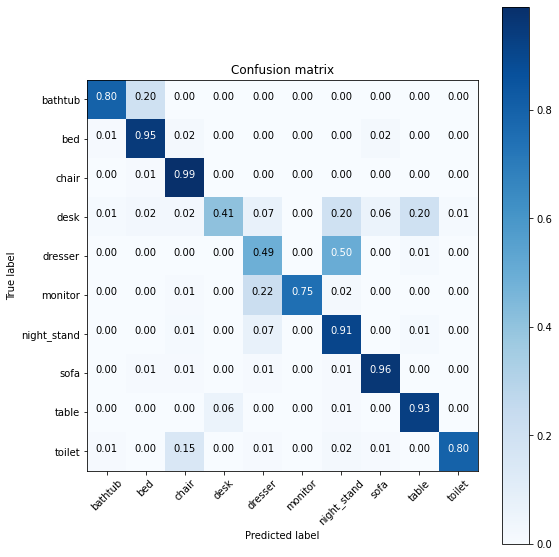

In [ ]:
plt.figure(figsize=(8,8))
plot_confusion_matrix(cm, list(classes.keys()), normalize=True)

Confusion matrix, without normalization


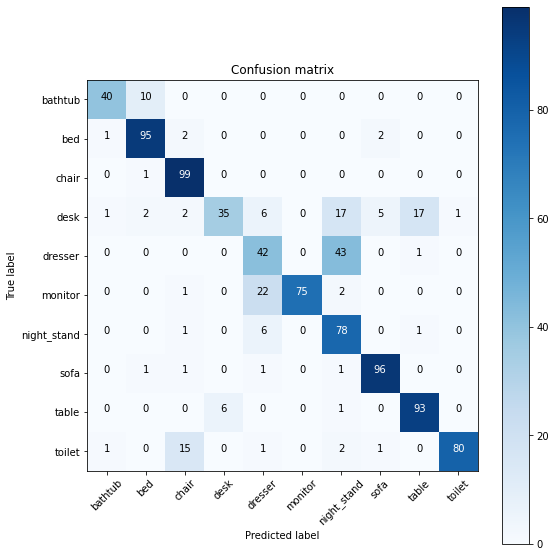

In [ ]:
plt.figure(figsize=(8,8))
plot_confusion_matrix(cm, list(classes.keys()), normalize=False)